# Numeric Features
The youtube datasets presents a variety of numeric variables. These variables and their relationship with the number of days a video remains on the trending page, as well as the number of days a video takes to reach the trending page.

The variables given in the dataset which will be considered in this section are:

- Views
- Likes
- Dislikes
- Publish Date
- Publish Time
- Trending Date 
- Category


## Motivation
Our motivation regarding this section is to understand which of the variables listed above are considered by youtube's algorithm, and to identify - given these features - if it is possible to predict how soon after being published a video will reach trending, and once it reaches trending how long it will remain trending.

In [166]:
import numpy as np 
import pandas as pd 
import os
import pandas as pd
import json
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
plt.style.use('ggplot')
import seaborn as sns
%matplotlib notebook

import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, LinearRegression, ElasticNet
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.metrics import mean_squared_error


from lime.lime_text import LimeTextExplainer
from tqdm import tqdm
import string
import random
import operator
import seaborn as sns
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from statistics import *
import concurrent.futures
import time
#import pyLDAvis.sklearn
from pylab import bone, pcolor, colorbar, plot, show, rcParams, savefig
import warnings
import nltk


# spaCy based imports
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English

# keras module for building LSTM 
#from keras.preprocessing.sequence import pad_sequences
#from keras.layers import Embedding, LSTM, Dense, Dropout
#from keras.preprocessing.text import Tokenizer
#from keras.callbacks import EarlyStopping
#from keras.models import Sequential
#import keras.utils as ku 
from tensorflow.keras import backend
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
import tensorflow.keras.utils as ku
# set seeds for reproducability
from numpy.random import seed
seed(1)

import warnings
warnings.filterwarnings("ignore")


In [45]:
ENG_df = pd.read_csv('../../data/data.csv')

#Publish_time column contains date and time together, first I will get the correct format.
ENG_df['publish_time'] = pd.to_datetime(ENG_df['publish_time'], errors='coerce', format='%Y-%m-%dT%H:%M:%S.%fZ')

#Removing any null values
ENG_df = ENG_df[ENG_df['trending_date'].notnull()]
ENG_df = ENG_df[ENG_df['publish_time'].notnull()]

#Separating previous publish_time column into two separate columns, publish date and publish time. 
ENG_df.insert(4, 'publish_date', ENG_df['publish_time'].dt.date)
ENG_df['publish_time'] = ENG_df['publish_time'].dt.time

#splitting publish_time column into separate hour, minute and second columns
ENG_df['publish_time'] = ENG_df['publish_time'].astype(str)
ENG_df[['hour','minute','second']] = ENG_df.publish_time.str.split(":", expand=True).astype(int)

#Adding like_rate, dislike_rate and comment_rate features to observe. I expect there to be a relationship between these features
#and time to reach trending, as well as time remained on trending. 
#These features represent viewer engagement, what percentage of viewers actually like, dislike and/or comment on the videos.
ENG_df['like_rate'] = ENG_df['likes']/ENG_df['views']*100
ENG_df['dislike_rate'] = ENG_df['dislikes']/ENG_df['views']*100
ENG_df['comment_rate'] = ENG_df['comment_count']/ENG_df['views']*100



In [46]:
US_init = ENG_df[ENG_df['country']== 'Country.us']
GB_init = ENG_df[ENG_df['country']== 'Country.gb']
CA_init = ENG_df[ENG_df['country']== 'Country.ca']

In [50]:
#Addingn columns into each region's dataframe which represents the number of days a video remains trending. 
occurances_US = US_init.groupby(['video_id']).size()
days_trending_US = occurances_US.to_frame(name = 'days_trending').reset_index()

US = pd.merge(left=US_init, right=days_trending_US, left_on='video_id', right_on='video_id', how='outer')

occurances_GB = GB_init.groupby(['video_id']).size()
days_trending_GB = occurances_GB.to_frame(name = 'days_trending').reset_index()

GB = pd.merge(left=GB_init, right=days_trending_GB, left_on='video_id', right_on='video_id', how='outer')

occurances_CA = CA_init.groupby(['video_id']).size()
days_trending_CA = occurances_CA.to_frame(name = 'days_trending').reset_index()

CA = pd.merge(left=CA_init, right=days_trending_CA, left_on='video_id', right_on='video_id', how='outer')


In [52]:
#Creating dataframes which consist of the first occurance of a video on trending, 
#as well as one for a video's last occurence on trending
US_last = US.drop_duplicates(['video_id'], keep='last')
US_first = US.drop_duplicates(['video_id'], keep='first')

GB_last = GB.drop_duplicates(['video_id'], keep='last')
GB_first = GB.drop_duplicates(['video_id'], keep='first')

CA_last = CA.drop_duplicates(['video_id'], keep='last')
CA_first = CA.drop_duplicates(['video_id'], keep='first')

#US.set_index(['trending_date','video_id'], inplace= True)
#US.set_index(['trending_date', 'video_id'], inplace=True)


## Feature Selection and Scoring

Now I will use sklearn's SelectKBest features on each region's dataset respectively. I will be considering, like rate, comment rate, dislike rate, hour, minute and second published. I will be assessing their applicability to days trending. Additionally, I will observe whether the number of views a video has on it's first occurance on trending is a valid predictor to the number of days a video remains on trending.

In [116]:
#Beginning with the US dataset. Considering the features regarding a video on it's first occurence on trending. 
#selecting features to consider for X_first as: views, like_rate, dislike_rate, comment_count, hour of publish, minute of publish and second of publish.
X_US_first = US_first.iloc[:,[8,22,23,24,19,20,21]]
y_US_first = US_first.iloc[:,-1]

X_GB_first = GB_first.iloc[:,[8,22,23,24,19,20,21]]
y_GB_first = GB_first.iloc[:,-1]

X_CA_first = CA_first.iloc[:,[8,22,23,24,19,20,21]]
y_CA_first = CA_first.iloc[:,-1]

X_US_last = US_last.iloc[:,[22,23,24,19,20,21]]
Y_US_last = US_last.iloc[:,-1]

X_GB_last = GB_last.iloc[:,[22,23,24,19,20,21]]
Y_GB_last = GB_last.iloc[:,-1]

X_CA_last = CA_last.iloc[:,[22,23,24,19,20,21]]
Y_CA_last = CA_last.iloc[:,-1]


### Consideration of numeric features vs days trending

In [89]:
US_first_selector = SelectKBest(score_func=mutual_info_regression, k=5)
US_first_new = US_first_selector.fit_transform(X_US_first, y_US_first)
#print(US_first_new[:5])
#print(X_US_first)

scores_US_first = pd.DataFrame({'Variable' : X_US_first.columns, 'Score': US_first_selector.scores_})
#pvalue_US_first = pd.DataFrame({'Variable' : X_US_first.columns, 'p values' : US_first_selector.pvalues_})

print("US_first scores")
print(scores_US_first.sort_values(by=['Score'], ascending=False))


US_first scores
       Variable     Score
4          hour  0.095078
1     like_rate  0.062591
0         views  0.052806
3  comment_rate  0.044677
2  dislike_rate  0.035275
5        minute  0.000000
6        second  0.000000


Selecting the best 5 features from the US dataset, the scores_ show that the best features to consider on the first occurance of a video on the trending page in order to predict the number of days it will remain trending are:
1. Hour uploaded
2. Like rate
3. Views
4. Comment rate
5. Dislike rate




In [90]:
GB_first_selector = SelectKBest(score_func=mutual_info_regression, k=5)
GB_first_new = GB_first_selector.fit_transform(X_GB_first, y_GB_first)
#print(US_first_new[:5])
#print(X_US_first)

scores_GB_first = pd.DataFrame({'Variable' : X_GB_first.columns, 'Score': GB_first_selector.scores_})
#pvalue_US_first = pd.DataFrame({'Variable' : X_US_first.columns, 'p values' : US_first_selector.pvalues_})
print("GB_first scores")
print(scores_GB_first.sort_values(by=['Score'], ascending=False))

GB_first scores
       Variable     Score
4          hour  0.077069
3  comment_rate  0.076039
1     like_rate  0.076016
2  dislike_rate  0.035719
0         views  0.029989
5        minute  0.024866
6        second  0.016916


Selecting the best 5 features from the GB dataset, the scores_ show that the best features to consider on the first occurance of a video on the trending page in order to predict the number of days it will remain trending are:
1. Hour uploaded
2. Comment rate
3. Like rate
3. Dislike rate
4. Views


In [91]:
CA_first_selector = SelectKBest(score_func=mutual_info_regression, k=5)
CA_first_new = CA_first_selector.fit_transform(X_CA_first, y_CA_first)


scores_CA_first = pd.DataFrame({'Variable' : X_CA_first.columns, 'Score': CA_first_selector.scores_})
#pvalue_US_first = pd.DataFrame({'Variable' : X_US_first.columns, 'p values' : US_first_selector.pvalues_})
print("CA_first scores")
print(scores_CA_first.sort_values(by=['Score'], ascending=False))

CA_first scores
       Variable     Score
4          hour  0.165783
3  comment_rate  0.027797
0         views  0.019604
1     like_rate  0.014241
6        second  0.009868
2  dislike_rate  0.007721
5        minute  0.005007


Selecting the best 5 features from the CA dataset, the scores_ show that the best features to consider on the first occurance of a video on the trending page in order to predict the number of days it will remain trending are:
1. Hour uploaded
2. Comment rate
3. Views
3. Like rate
4. Second uploaded 

It definitely holds up to the polite canadian stereotype that dislike_rate is not even in the best 5 features! :)





Next I will perform the same feature selection on the last occurence of a video on the trending page. As a result of it being the last occurrence on trending, I will mitigate the views feature from selection.

In [95]:
US_last_selector = SelectKBest(score_func=mutual_info_regression, k=5)
US_last_new = US_last_selector.fit_transform(X_US_last, Y_US_last)

US_scores_last = pd.DataFrame({'Variable' : X_US_last.columns, 'Score': US_last_selector.scores_})

print(US_scores_last.sort_values(by=['Score'], ascending=False))

       Variable     Score
4        minute  0.025132
0     like_rate  0.019735
1  dislike_rate  0.012333
2  comment_rate  0.006312
3          hour  0.000396
5        second  0.000000


Considering the last occurrence of a video on trending from the US, the 5 best selected features were:

1. Minute of upload
2. Like rate
3. Dislike rate
4. Comment rate
5. Hour uploaded

However, the scores are extremely low for all predictors which is indicative of a large amount of noise.



In [99]:
GB_last_selector = SelectKBest(score_func=mutual_info_regression, k=5)
GB_last_new = GB_last_selector.fit_transform(X_GB_last, Y_GB_last)

GB_scores_last = pd.DataFrame({'Variable' : X_GB_last.columns, 'Score': GB_last_selector.scores_})

print(GB_scores_last.sort_values(by=['Score'], ascending=False))

       Variable     Score
4        minute  0.029820
3          hour  0.024951
1  dislike_rate  0.009726
5        second  0.009420
2  comment_rate  0.007655
0     like_rate  0.006376


Considering the last occurrence of a video on trending from GB, the 5 best selected features were:

1. Minute of upload
2. Hour uploaded
3. Dislike rate
4. Second uploaded
5. Comment rate

However, the scores are extremely low for all predictors which is indicative of a large amount of noise.


In [100]:
CA_last_selector = SelectKBest(score_func=mutual_info_regression, k=5)
CA_last_new = CA_last_selector.fit_transform(X_CA_last, Y_CA_last)

CA_scores_last = pd.DataFrame({'Variable' : X_CA_last.columns, 'Score': CA_last_selector.scores_})

print(CA_scores_last.sort_values(by=['Score'], ascending=False))

       Variable     Score
0     like_rate  0.022859
2  comment_rate  0.009069
3          hour  0.006022
1  dislike_rate  0.003319
5        second  0.002994
4        minute  0.000488


Considering the last occurrence of a video on trending from CA, the 5 best selected features were:

1. Like rate
2. Comment rate
3. Hour uploaded
4. Dislike rate
5. Second uploaded

However, the scores are extremely low for all predictors which is indicative of a large amount of noise.

In [102]:
#converting the publish date and trending date columns to datetime format, so I can calculate time delta for days_to_trending.
#US dataframe first
US_first['publish_date'] = pd.to_datetime(US_first['publish_date'])
US_first['trending_date'] = pd.to_datetime(US_first['trending_date'], format="%y.%d.%m")
US_first['days_to_trending'] = (US_first['trending_date'] - US_first['publish_date'])
US_first['days_to_trending'] = US_first['days_to_trending'].dt.days.astype(int)

#GB dataframe
GB_first['publish_date'] = pd.to_datetime(GB_first['publish_date'])
GB_first['trending_date'] = pd.to_datetime(GB_first['trending_date'], format="%y.%d.%m")
GB_first['days_to_trending'] = (GB_first['trending_date'] - GB_first['publish_date'])
GB_first['days_to_trending'] = GB_first['days_to_trending'].dt.days.astype(int)

#CA dataframe
CA_first['publish_date'] = pd.to_datetime(CA_first['publish_date'])
CA_first['trending_date'] = pd.to_datetime(CA_first['trending_date'], format="%y.%d.%m")
CA_first['days_to_trending'] = (CA_first['trending_date'] - CA_first['publish_date'])
CA_first['days_to_trending'] = CA_first['days_to_trending'].dt.days.astype(int)


### Consideration of days taken to reach the trending page

Next I consider the potential relationship between the time taken for a video to reach trending and the days it remains on trending. I will simply add this as a feature to X_diff, and perform the same SelectKBest feature selection as above, selecting the best 5 features, to see how this new feature scores amongst the previously selected features.

In [112]:
#features considered are, hour, minute, second, like rate, dislike rate, comment rate, days to trending
X_US_diff = US_first.iloc[:,[19,20,21,22,23,24,26]]
#target is still days_trending
y_US_diff = US_first.iloc[:,25]

X_GB_diff = GB_first.iloc[:,[19,20,21,22,23,24,26]]
y_GB_diff = GB_first.iloc[:,25]

X_CA_diff = CA_first.iloc[:,[19,20,21,22,23,24,26]]
y_CA_diff = CA_first.iloc[:,25]

In [113]:
US_diff_selector = SelectKBest(score_func=mutual_info_regression, k=5)
US_diff_new = US_diff_selector.fit_transform(X_US_diff, y_US_diff)

US_diff_scores = pd.DataFrame({'Variable' : X_US_diff.columns, 'Score': US_diff_selector.scores_})

print(US_diff_scores.sort_values(by=['Score'], ascending=False))

           Variable     Score
6  days_to_trending  0.095979
3         like_rate  0.047504
5      comment_rate  0.032055
4      dislike_rate  0.016808
1            minute  0.014406
0              hour  0.007897
2            second  0.002456


Considering the US dataset, and introducing the consideration of the feature days_to_trending, the bset 5 features are:
1. days_to_trending
2. Like rate
3. Comment rate
4. Dislike rate
5. Minute uploaded

This shows that, in the US dataset, days_to_trending is the best predictor out of all the numerical values, for how long a video will remain trending.

In [114]:
CA_diff_selector = SelectKBest(score_func=mutual_info_regression, k=5)
CA_diff_new = CA_diff_selector.fit_transform(X_CA_diff, y_CA_diff)

CA_diff_scores = pd.DataFrame({'Variable' : X_CA_diff.columns, 'Score': CA_diff_selector.scores_})

print(CA_diff_scores.sort_values(by=['Score'], ascending=False))

           Variable     Score
3         like_rate  0.025914
5      comment_rate  0.010425
1            minute  0.007495
4      dislike_rate  0.007286
0              hour  0.006297
6  days_to_trending  0.004991
2            second  0.000000


Considering the CA dataset, and introducing the consideration of the feature days_to_trending, the bset 5 features are:
1. Like rate
2. Comment rate
3. Minute uploaded
4. Dislike rate
5. Hour uploaded


In [115]:
GB_diff_selector = SelectKBest(score_func=mutual_info_regression, k=5)
GB_diff_new = GB_diff_selector.fit_transform(X_GB_diff, y_GB_diff)

GB_diff_scores = pd.DataFrame({'Variable' : X_GB_diff.columns, 'Score': GB_diff_selector.scores_})

print(GB_diff_scores.sort_values(by=['Score'], ascending=False))

           Variable     Score
6  days_to_trending  0.162844
3         like_rate  0.033257
1            minute  0.031215
2            second  0.028924
4      dislike_rate  0.012332
5      comment_rate  0.010969
0              hour  0.005726


Considering the CA dataset, and introducing the consideration of the feature days_to_trending, the bset 5 features are:
1. days_to_trending
2. Like rate
3. Minute uploaded
4. Second uploaded
5. Dislike rate

Once again, the best predictor as to how long a video will trend, in the GB dataset, is days_to_trending. The score assigned to this feature is significantly greater than all other features considered.


The above feature selection showed that for the US and for GB, days_to_trending was the strongest predictor for the number of days a video remains on trending. This did not seem to be the case for the CA dataset, however. 


I have ignored number of likes and views despite their higher scores due to the fact that the DataFrame consisted only of the first entry of each video. The number of views a video has when it first appears on trending has nothing to do with predicting whether or not it reaches trending because this can only be known after the fact. However, like rate, comment rate, dislike rate and hour uploaded can all be observed prior to the first appearance of a video on the trending page, and can therefore give a better idea to the content creater how their video is performing relative to previous videos which appeared on trending. 

I believe that, given more data prior to the initial trending date, if we were able to observe the rate of increase of views, that would be an important feature to consider.

## Correlation between all features

After adding in new features, days_to_trending, as well as separating my datetime.time column into hour, minute and second. I will assess the correlations between each of these features to understand multicollinearity present in my dataset, as well as correlations with features and my target variables. This will help inform my supervised approach to follow.

<IPython.core.display.Javascript object>


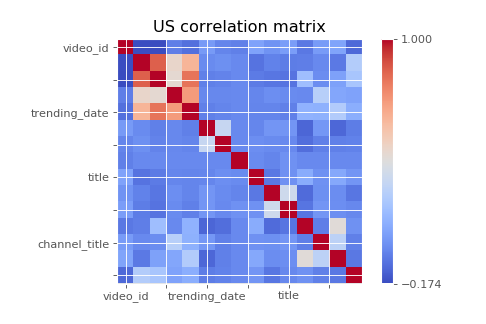

In [120]:
US_corr_matrix = US[0:-1].corr()
#print(US_corr_matrix)

fig, ax = plt.subplots()

heatmap = ax.imshow(US_corr_matrix, interpolation='nearest', cmap=cm.coolwarm)

cbar_min = US_corr_matrix.min().min()
cbar_max = US_corr_matrix.max().max()
cbar = fig.colorbar(heatmap, ticks=[cbar_min, cbar_max])

labels=['']
for column in US[0:-1]:
    labels.append(column)
    labels.append('')
ax.set_yticklabels(labels,minor=False)
ax.set_xticklabels(labels, minor=False)

plt.title('US correlation matrix')
plt.show()

<IPython.core.display.Javascript object>


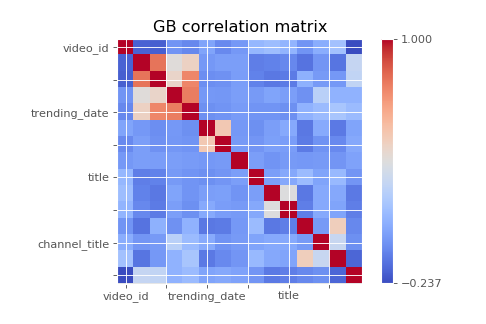

In [121]:
GB_corr_matrix = GB[0:-1].corr()

fig, ax = plt.subplots()

heatmap = ax.imshow(GB_corr_matrix, interpolation='nearest', cmap=cm.coolwarm)

cbar_min = GB_corr_matrix.min().min()
cbar_max = GB_corr_matrix.max().max()
cbar = fig.colorbar(heatmap, ticks=[cbar_min, cbar_max])

labels=['']
for column in GB[0:-1]:
    labels.append(column)
    labels.append('')
ax.set_yticklabels(labels,minor=False)
ax.set_xticklabels(labels, minor=False)

plt.title('GB correlation matrix')
plt.show()

<IPython.core.display.Javascript object>


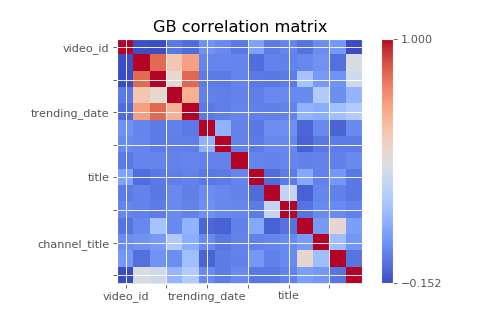

In [122]:
CA_corr_matrix = CA[0:-1].corr()

fig, ax = plt.subplots()

heatmap = ax.imshow(CA_corr_matrix, interpolation='nearest', cmap=cm.coolwarm)

cbar_min = CA_corr_matrix.min().min()
cbar_max = CA_corr_matrix.max().max()
cbar = fig.colorbar(heatmap, ticks=[cbar_min, cbar_max])

labels=['']
for column in CA[0:-1]:
    labels.append(column)
    labels.append('')
ax.set_yticklabels(labels,minor=False)
ax.set_xticklabels(labels, minor=False)

plt.title('GB correlation matrix')
plt.show()

<IPython.core.display.Javascript object>


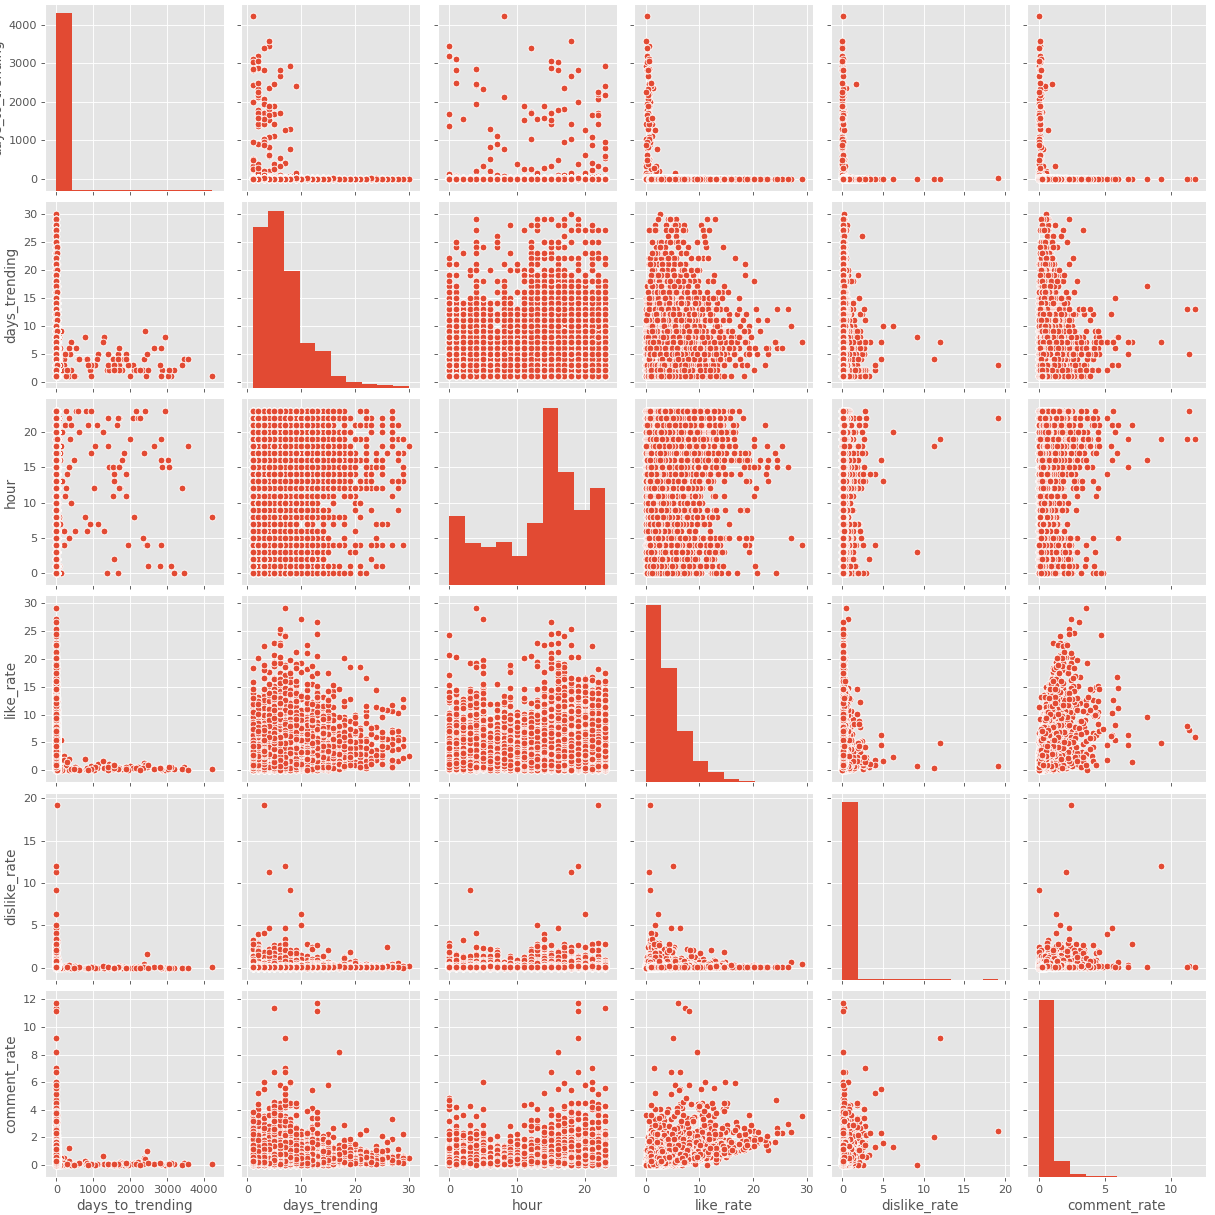

In [147]:
US_comp_df = pd.DataFrame(US_first, columns = ['days_to_trending', 'days_trending', 'hour', 'like_rate', 'dislike_rate', 'comment_rate'])

sns.pairplot(US_comp_df)

<IPython.core.display.Javascript object>


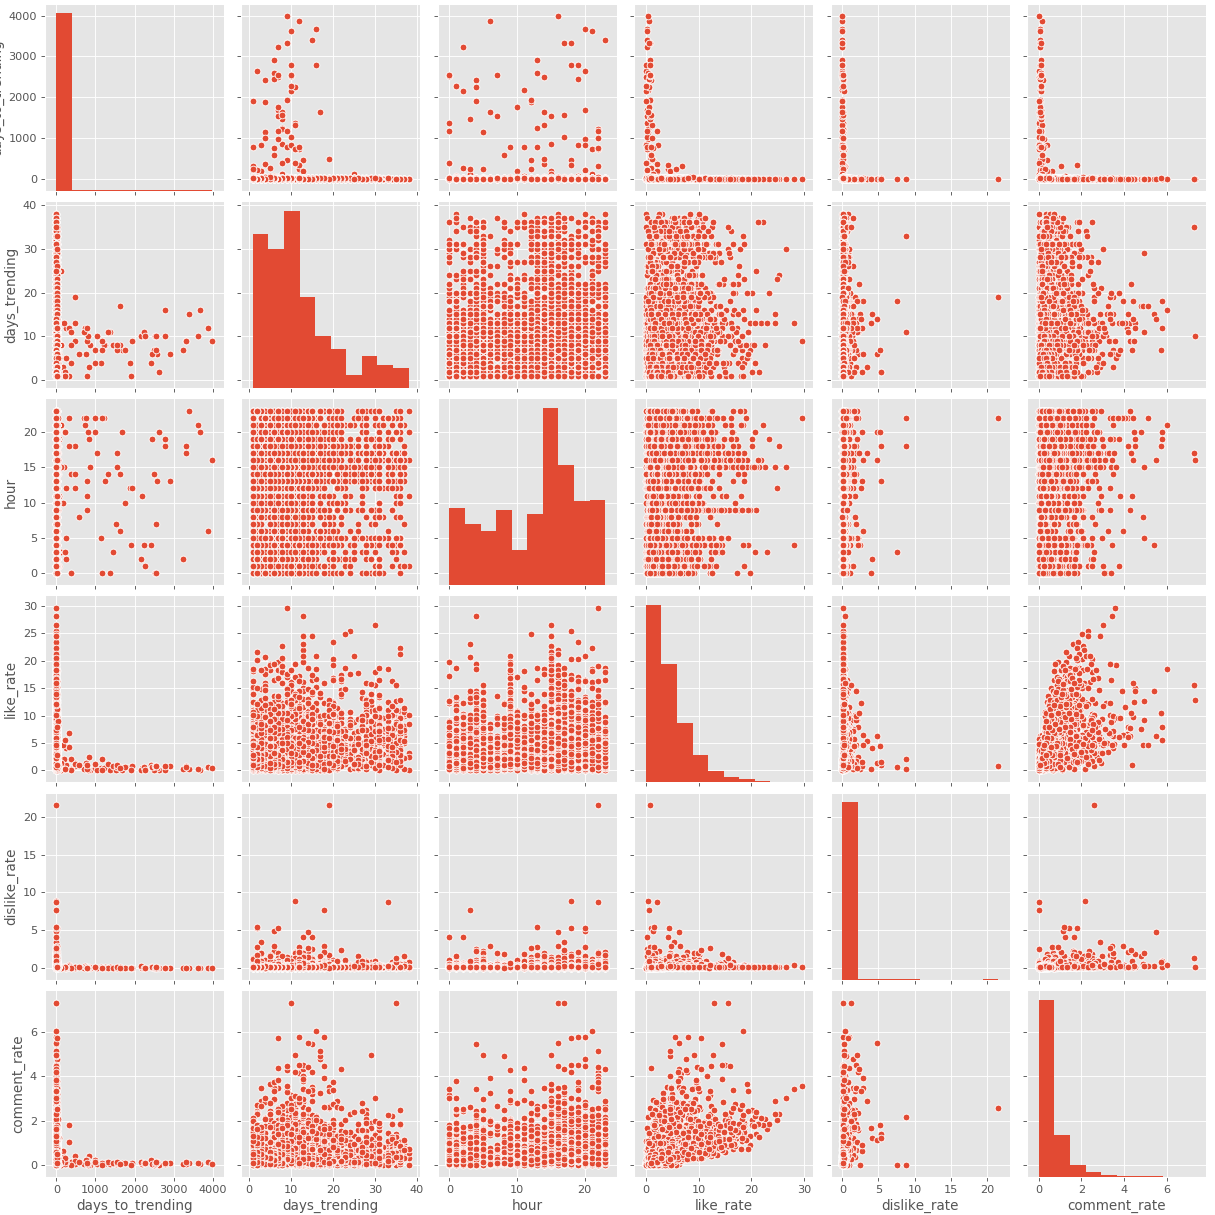

In [170]:
GB_comp_df = pd.DataFrame(GB_first, columns = ['days_to_trending', 'days_trending', 'hour', 'like_rate', 'dislike_rate', 'comment_rate'])

sns.pairplot(GB_comp_df)

<IPython.core.display.Javascript object>


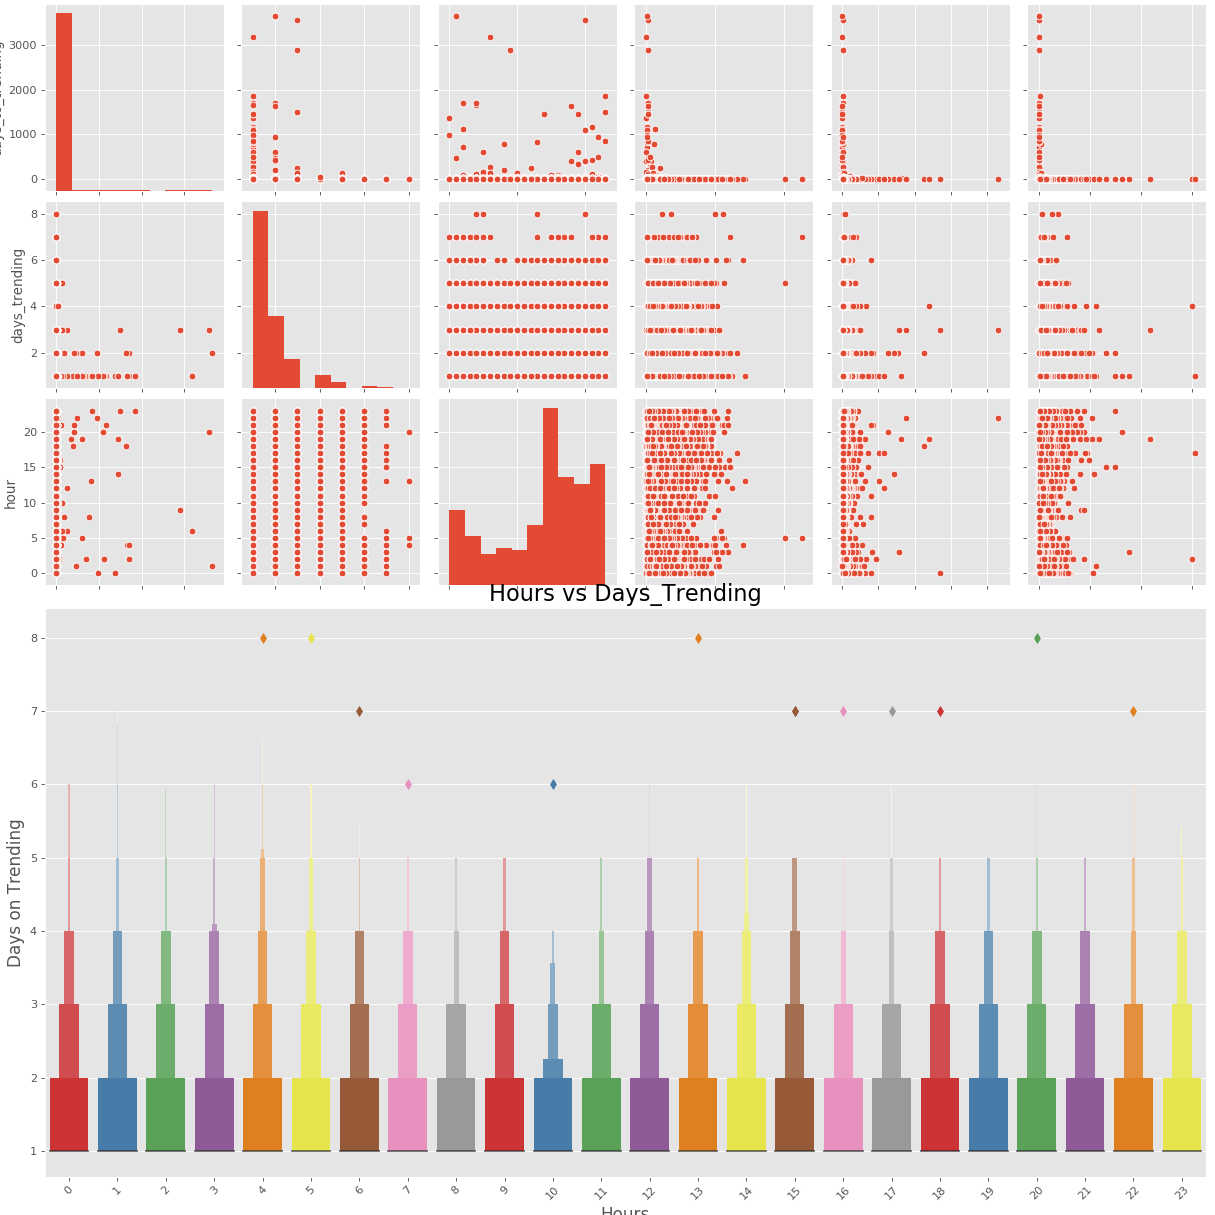

In [148]:
CA_comp_df = pd.DataFrame(CA_first, columns = ['days_to_trending', 'days_trending', 'hour', 'like_rate', 'dislike_rate', 'comment_rate'])

sns.pairplot(CA_comp_df)

The above pairplots reinforces the relationships highlighted through the previous SelectKBest features implementations. However, it further highlights the weakness of all numeric features' relationship with the number of days taken to reach trending, as well as the number of days a video will remain on trending.

There is such large variance in all relationships between all numeric features and the desired targets (days_to_trending and days_trendin). Therefore I believe that there is significant external influence beyond what can be measured numerically in these datasets. 

## Distribution of likerate, dislikerate, comment rate and views

<IPython.core.display.Javascript object>


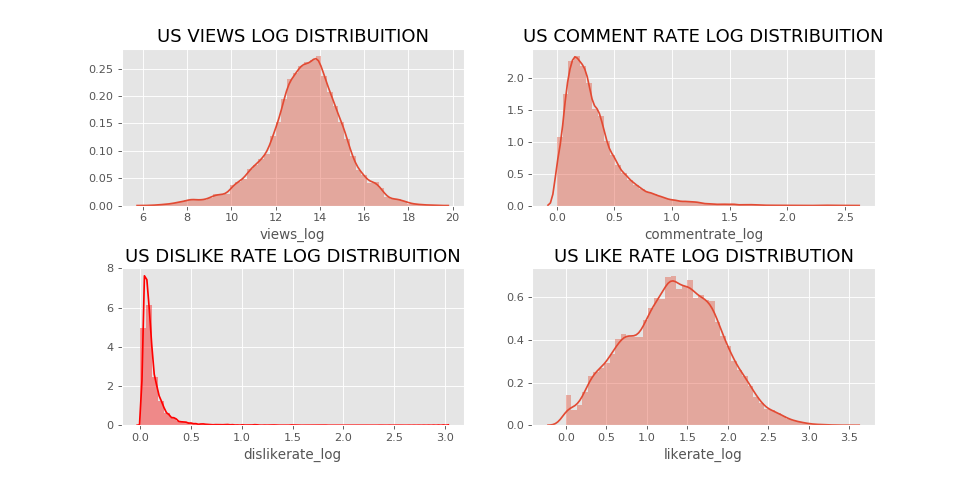

'\nViews, Comments, Dislikes and Likes are all normally distributed.'

In [130]:
US['likes_log'] = np.log(US['likes'] + 1)
US['likerate_log'] = np.log((US['likes']/US['views']*100) + 1)
US['dislikerate_log'] = np.log((US['dislikes']/US['views']*100) + 1)
US['commentrate_log'] = np.log((US['comment_count']/US['views']*100) + 1)
US['views_log'] = np.log(US['views'] + 1)
US['dislikes_log'] = np.log(US['dislikes'] + 1)
US['comment_log'] = np.log(US['comment_count'] + 1)

plt.figure(figsize = (12,6))

plt.subplot(221)
g1 = sns.distplot(US['views_log'])
g1.set_title("US VIEWS LOG DISTRIBUITION", fontsize=16)

#plt.subplot(224)
#g2 = sns.distplot(US['likes_log'],color='green')
#g2.set_title('LIKES LOG DISTRIBUITION', fontsize=16)

plt.subplot(223)
g3 = sns.distplot(US['dislikerate_log'], color='r')
g3.set_title("US DISLIKE RATE LOG DISTRIBUITION", fontsize=16)

plt.subplot(222)
g4 = sns.distplot(US['commentrate_log'])
g4.set_title("US COMMENT RATE LOG DISTRIBUITION", fontsize=16)

plt.subplot(224)
g4 = sns.distplot(US['likerate_log'])
g4.set_title("US LIKE RATE LOG DISTRIBUTION", fontsize=16)

plt.subplots_adjust(wspace = 0.2, hspace = 0.4,top = 0.9)

plt.show()

'''
Views, Comments, Dislikes and Likes are all normally distributed.'''

<IPython.core.display.Javascript object>


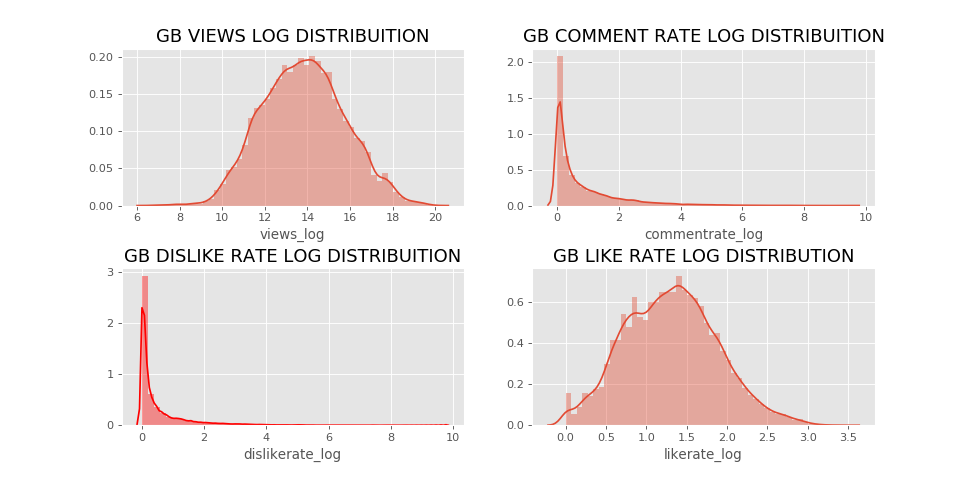

In [132]:
GB['likes_log'] = np.log(GB['likes'] + 1)
GB['likerate_log'] = np.log((GB['likes']/GB['views']*100) + 1)
GB['dislikerate_log'] = np.log((GB['dislikes']/US['views']*100) + 1)
GB['commentrate_log'] = np.log((GB['comment_count']/US['views']*100) + 1)
GB['views_log'] = np.log(GB['views'] + 1)
GB['dislikes_log'] = np.log(GB['dislikes'] + 1)
GB['comment_log'] = np.log(GB['comment_count'] + 1)

plt.figure(figsize = (12,6))

plt.subplot(221)
g1 = sns.distplot(GB['views_log'])
g1.set_title("GB VIEWS LOG DISTRIBUITION", fontsize=16)

plt.subplot(223)
g3 = sns.distplot(GB['dislikerate_log'], color='r')
g3.set_title("GB DISLIKE RATE LOG DISTRIBUITION", fontsize=16)

plt.subplot(222)
g4 = sns.distplot(GB['commentrate_log'])
g4.set_title("GB COMMENT RATE LOG DISTRIBUITION", fontsize=16)

plt.subplot(224)
g4 = sns.distplot(GB['likerate_log'])
g4.set_title("GB LIKE RATE LOG DISTRIBUTION", fontsize=16)

plt.subplots_adjust(wspace = 0.2, hspace = 0.4,top = 0.9)

plt.show()

<IPython.core.display.Javascript object>


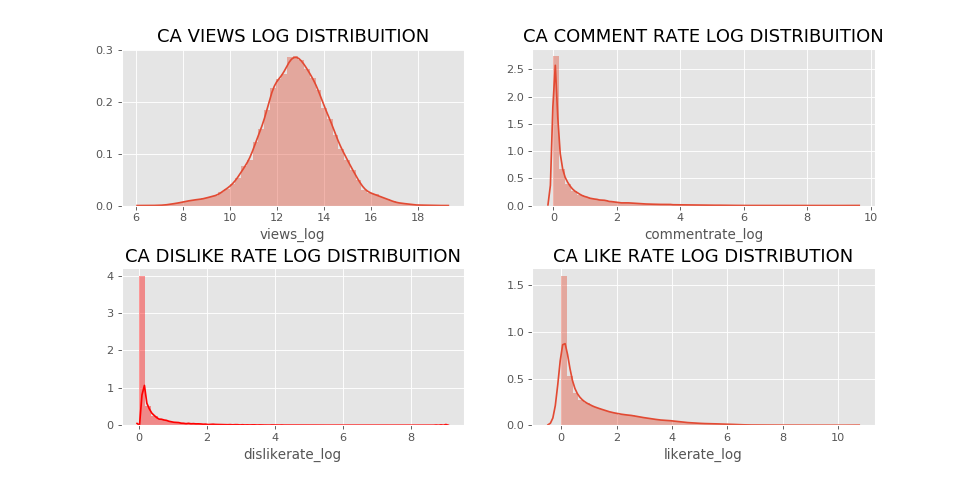

In [133]:
CA['likes_log'] = np.log(CA['likes'] + 1)
CA['likerate_log'] = np.log((CA['likes']/GB['views']*100) + 1)
CA['dislikerate_log'] = np.log((CA['dislikes']/US['views']*100) + 1)
CA['commentrate_log'] = np.log((CA['comment_count']/US['views']*100) + 1)
CA['views_log'] = np.log(CA['views'] + 1)
CA['dislikes_log'] = np.log(CA['dislikes'] + 1)
CA['comment_log'] = np.log(CA['comment_count'] + 1)

plt.figure(figsize = (12,6))

plt.subplot(221)
g1 = sns.distplot(CA['views_log'])
g1.set_title("CA VIEWS LOG DISTRIBUITION", fontsize=16)

plt.subplot(223)
g3 = sns.distplot(CA['dislikerate_log'], color='r')
g3.set_title("CA DISLIKE RATE LOG DISTRIBUITION", fontsize=16)

plt.subplot(222)
g4 = sns.distplot(CA['commentrate_log'])
g4.set_title("CA COMMENT RATE LOG DISTRIBUITION", fontsize=16)

plt.subplot(224)
g4 = sns.distplot(CA['likerate_log'])
g4.set_title("CA LIKE RATE LOG DISTRIBUTION", fontsize=16)

plt.subplots_adjust(wspace = 0.2, hspace = 0.4,top = 0.9)

plt.show()

It can be observed, from the above distribution graphs that views, comment rate, dislike rate and like rate are all normally distributed, and are similarly skewed between regions. 

## Like rate distribution by category

Next, I am going to consider the like rate distribution by category, per region. 

<IPython.core.display.Javascript object>


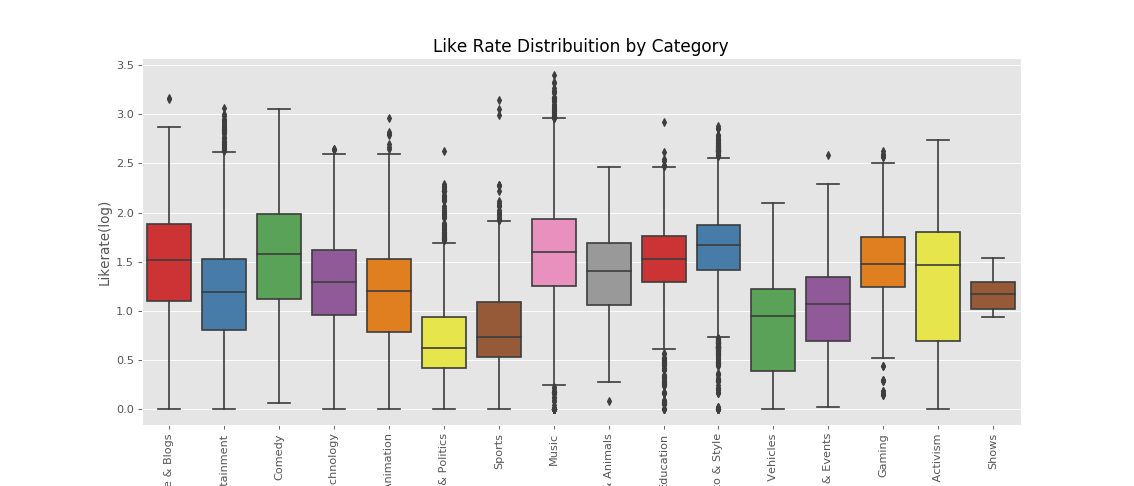

In [134]:
plt.figure(figsize = (14,6))

g = sns.boxplot(x='category_name', y='likerate_log', data=US, palette="Set1")
g.set_xticklabels(g.get_xticklabels(),rotation=90)
g.set_title("US Like Rate Distribuition by Category", fontsize=15)
g.set_xlabel("", fontsize=12)
g.set_ylabel("Likerate(log)", fontsize=12)
plt.show()

<IPython.core.display.Javascript object>


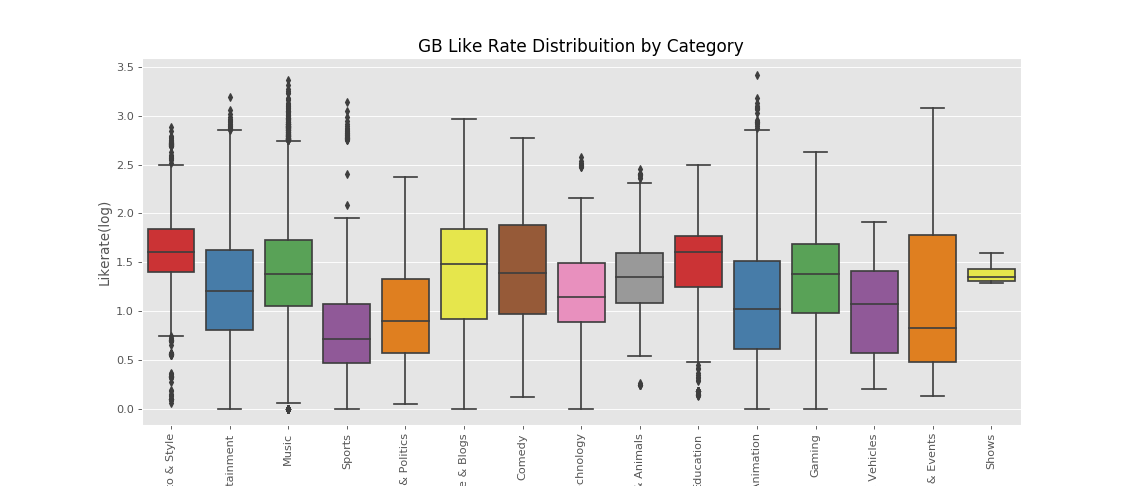

In [135]:
plt.figure(figsize = (14,6))

g = sns.boxplot(x='category_name', y='likerate_log', data=GB, palette="Set1")
g.set_xticklabels(g.get_xticklabels(),rotation=90)
g.set_title("GB Like Rate Distribuition by Category", fontsize=15)
g.set_xlabel("", fontsize=12)
g.set_ylabel("Likerate(log)", fontsize=12)
plt.show()

<IPython.core.display.Javascript object>


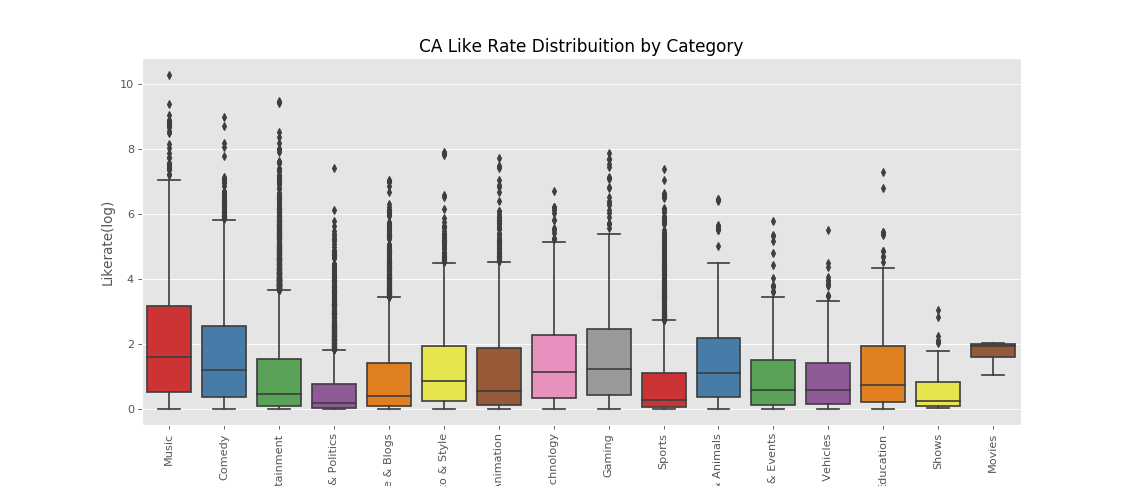

In [136]:
plt.figure(figsize = (14,6))

g = sns.boxplot(x='category_name', y='likerate_log', data=CA, palette="Set1")
g.set_xticklabels(g.get_xticklabels(),rotation=90)
g.set_title("CA Like Rate Distribuition by Category", fontsize=15)
g.set_xlabel("", fontsize=12)
g.set_ylabel("Likerate(log)", fontsize=12)
plt.show()

It is clear that GB and US trending distributions are very similar, whereas CA varies greatly. This has been apparent throughout my analysis thus far, but is clear now when considering like rate distribution by category. The variety in distribution by category per region highlights that like_rate is a sporadic feature and may not be the strongest predictor for the number of days a video will remain trending.

## Top upload hours

Next I will observe the relationship between hour uploaded and like rate, comment rate and dislike rate. This will be done for each region independently. 

<IPython.core.display.Javascript object>


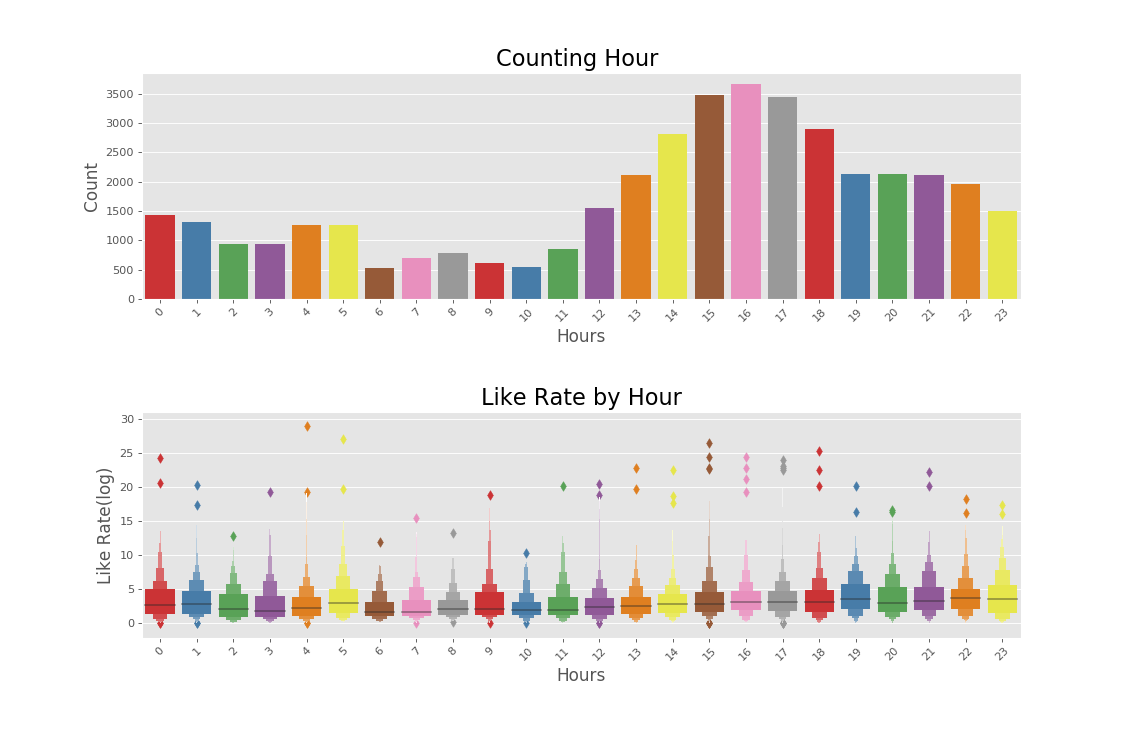

In [143]:
plt.figure(figsize = (14,9))

plt.subplot(211)
g = sns.countplot('hour', data=US, palette="Set1")
g.set_xticklabels(g.get_xticklabels(),rotation=45)
g.set_title("Counting Hour ", fontsize=20)
g.set_xlabel("Hours", fontsize=15)
g.set_ylabel("Count", fontsize=15)

plt.subplot(212)
g1 = sns.lvplot(x='hour', y='like_rate', data=US, palette="Set1")
g1.set_xticklabels(g.get_xticklabels(),rotation=45)
g1.set_title("Like Rate by Hour", fontsize=20)
g1.set_xlabel("Hours", fontsize=15)
g1.set_ylabel("Like Rate(log)", fontsize=15)

plt.subplots_adjust(hspace = 0.5, top = 0.9)

plt.show()

For the US, the most popular hour to upload in is 16:00. It can also be observed that the mean like_rate peaks around 19:00. This might be due to the fact that a content creator's core audience will be viewing a video within a few hours of upload and therefore the like rate will increase during this time. 

<IPython.core.display.Javascript object>


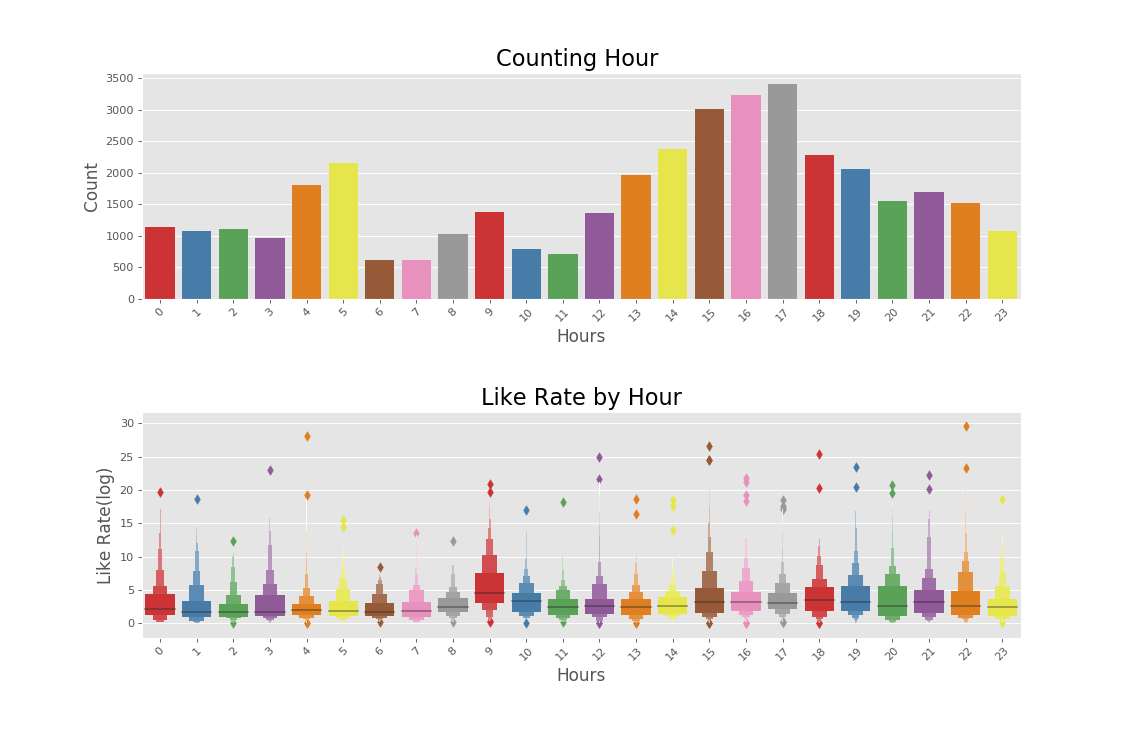

In [142]:
plt.figure(figsize = (14,9))

plt.subplot(211)
g = sns.countplot('hour', data=GB, palette="Set1")
g.set_xticklabels(g.get_xticklabels(),rotation=45)
g.set_title("Counting Hour ", fontsize=20)
g.set_xlabel("Hours", fontsize=15)
g.set_ylabel("Count", fontsize=15)

plt.subplot(212)
g1 = sns.lvplot(x='hour', y='like_rate', data=GB, palette="Set1")
g1.set_xticklabels(g.get_xticklabels(),rotation=45)
g1.set_title("Like Rate by Hour", fontsize=20)
g1.set_xlabel("Hours", fontsize=15)
g1.set_ylabel("Like Rate(log)", fontsize=15)

plt.subplots_adjust(hspace = 0.5, top = 0.9)

plt.show()

For GB, the most popular hour to upload in is 17:00. It can also be observed that the mean like_rate peaks around 9:00. 

<IPython.core.display.Javascript object>


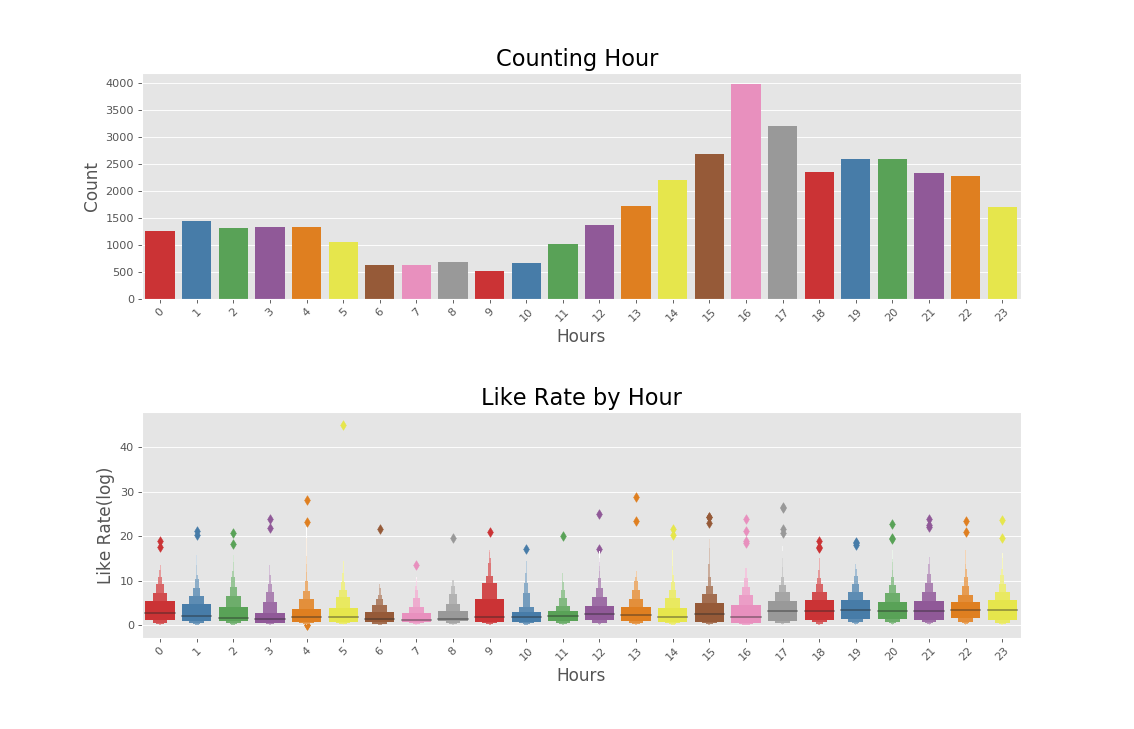

In [144]:
plt.figure(figsize = (14,9))

plt.subplot(211)
g = sns.countplot('hour', data=CA, palette="Set1")
g.set_xticklabels(g.get_xticklabels(),rotation=45)
g.set_title("Counting Hour ", fontsize=20)
g.set_xlabel("Hours", fontsize=15)
g.set_ylabel("Count", fontsize=15)

plt.subplot(212)
g1 = sns.lvplot(x='hour', y='like_rate', data=CA, palette="Set1")
g1.set_xticklabels(g.get_xticklabels(),rotation=45)
g1.set_title("Like Rate by Hour", fontsize=20)
g1.set_xlabel("Hours", fontsize=15)
g1.set_ylabel("Like Rate(log)", fontsize=15)

plt.subplots_adjust(hspace = 0.5, top = 0.9)

plt.show()

For CA, the most popular upload hour is 16:00, and it can be observed that the like rate peaks around 17:00.

<IPython.core.display.Javascript object>


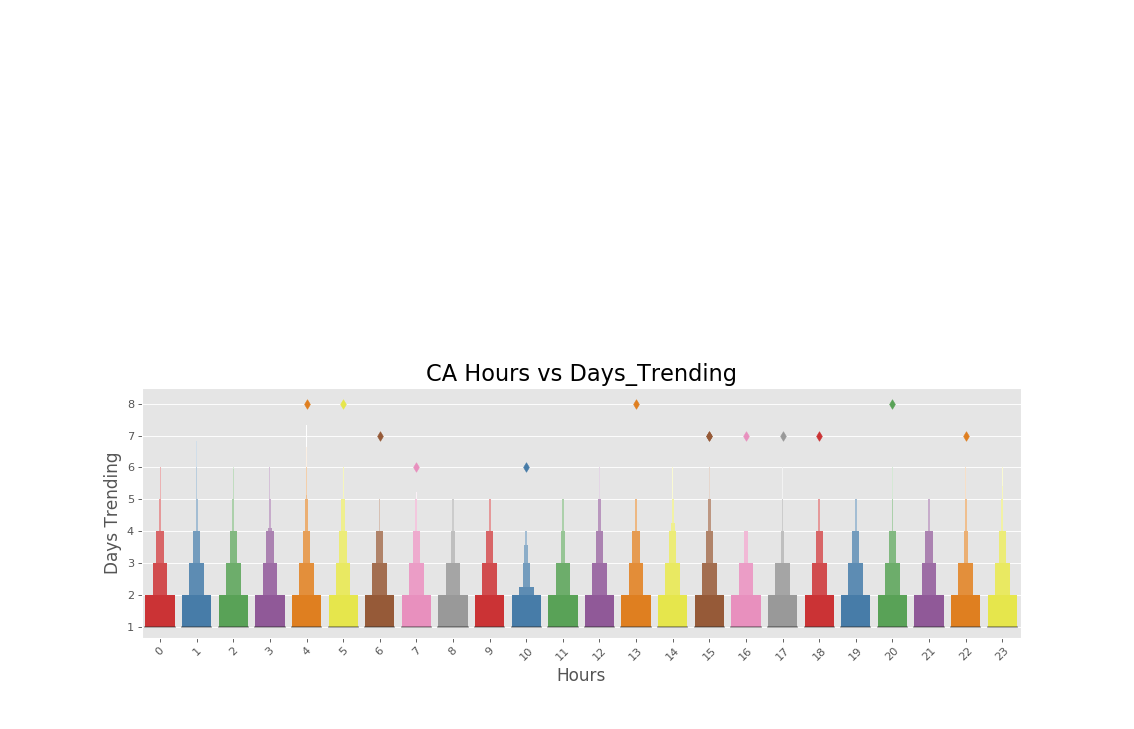

In [159]:
plt.figure(figsize = (14,9))
plt.subplot(212)
g1 = sns.lvplot(x='hour', y='days_trending', data=CA_first, palette="Set1")
g1.set_xticklabels(g.get_xticklabels(),rotation=45)
g1.set_title("CA Hours vs Days_Trending", fontsize=20)
g1.set_xlabel("Hours", fontsize=15)
g1.set_ylabel("Days Trending", fontsize=15)

plt.show()

<IPython.core.display.Javascript object>


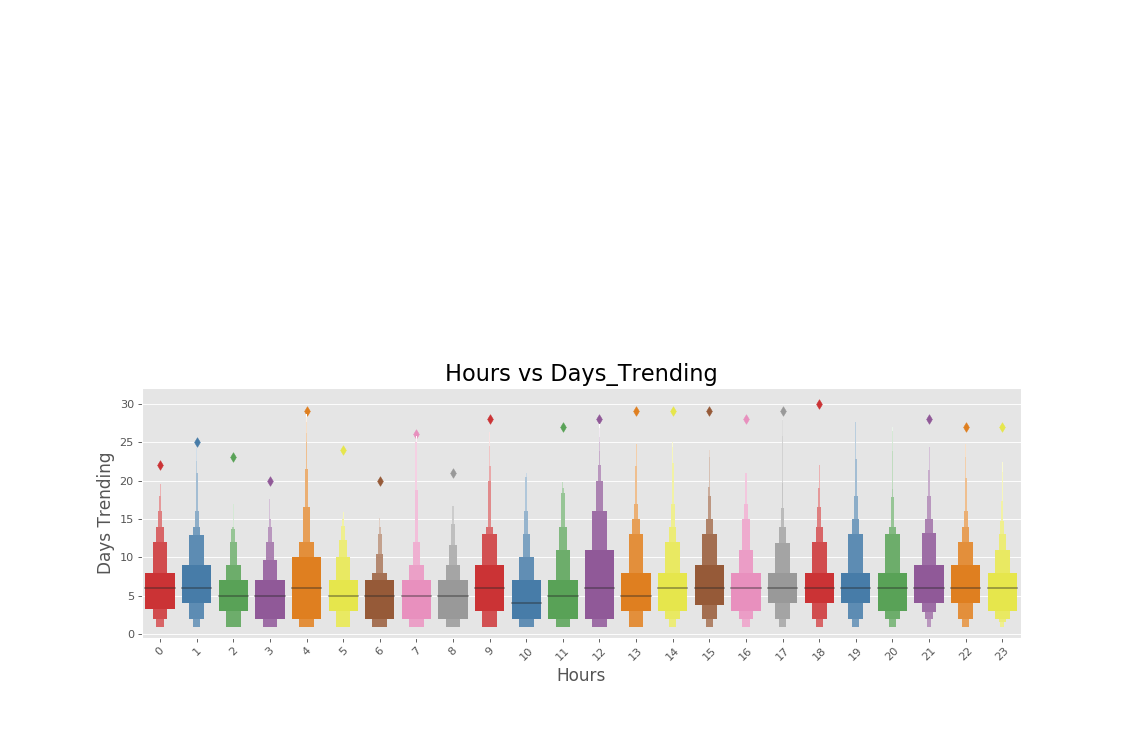

In [155]:
plt.figure(figsize = (14,9))

plt.subplot(212)
g1 = sns.lvplot(x='hour', y='days_trending', data=US_first, palette="Set1")
g1.set_xticklabels(g.get_xticklabels(),rotation=45)
g1.set_title("US Hours vs Days_Trending", fontsize=20)
g1.set_xlabel("Hours", fontsize=15)
g1.set_ylabel("Days Trending", fontsize=15)

plt.show()

<IPython.core.display.Javascript object>


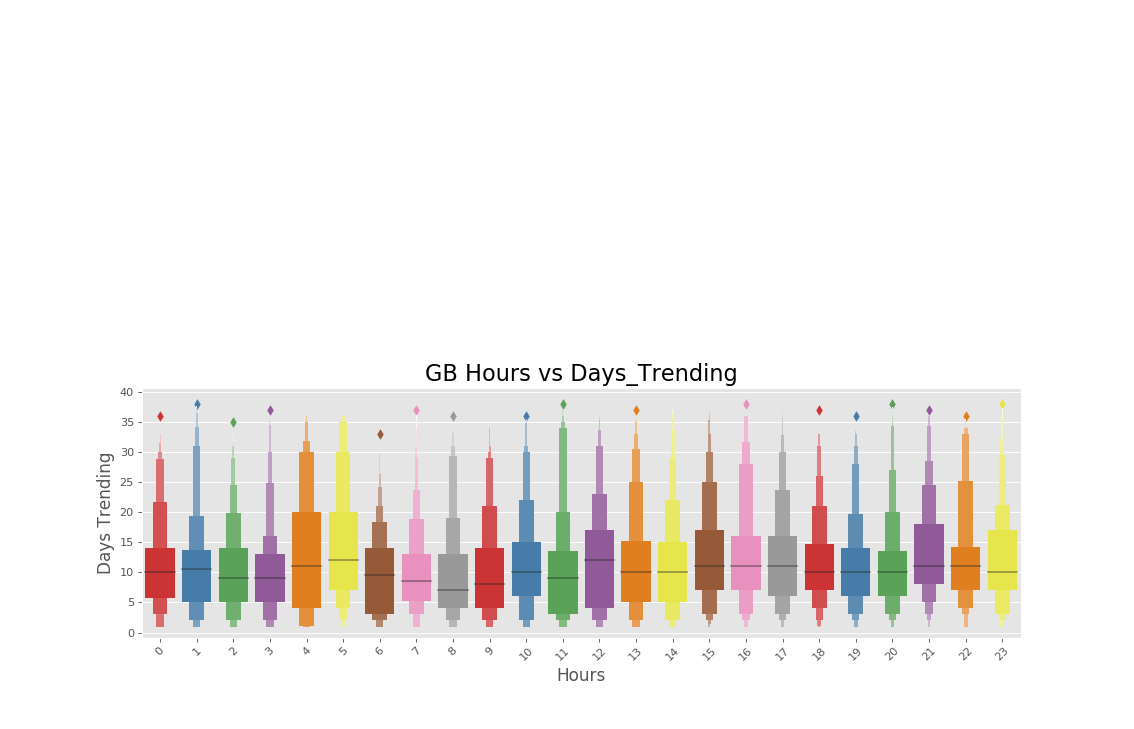

In [160]:
plt.figure(figsize = (14,9))

plt.subplot(212)
g1 = sns.lvplot(x='hour', y='days_trending', data=GB_first, palette="Set1")
g1.set_xticklabels(g.get_xticklabels(),rotation=45)
g1.set_title("GB Hours vs Days_Trending", fontsize=20)
g1.set_xlabel("Hours", fontsize=15)
g1.set_ylabel("Days Trending", fontsize=15)

plt.show()

There appears to be no clear trend regarding the hour a video is uploaded and the number of days it remains on trending, across all three regions.

## Supervised learning based on best selected features
Considering the features selected by SelectKBest features. First I will fit an elastic net regressor to my features, predict for my target variable days_to_trending and then evaluate the accuracy of the model, with respects to each region (CA, US and GB).

In [168]:
# I will be implementing, and testing an ElasticNet regressor for this problem, due to the issues faced in datasets 
# with a large number of variablesand the ways in which ridge regression can mitigate these issues as well as
# simplifying the model through the consideration of Lasso regression. A tradeoff between the two approaches will be considered using 
# hyperparameter tuning in order to increase the accuracy of the model.

#hour, likerate, comment rate, dislike rate, 

#I will begin by learning a model to predict the days to trending based off of the selected best 4 relevant features for the considered target variable

US_X = US_comp_df.iloc[:,2:]
US_y = US_comp_df['days_to_trending']
#choose random state for reproducibility 
X_US_train, X_US_test, y_US_train, y_US_test = train_test_split(US_X,US_y, test_size = 0.3, random_state=24)

#creating the space for hyperparameter tuning, of the L1 penalty. This determines the tradeoff between L1 lasso regularisation and L2 ridge regularisation. to calculate the best penalty term for regularisation.
l1_ = np.linspace(0, 1, 50)
tune_grid = {'l1_ratio': l1_}

#regressor
elastic = ElasticNet()

#grid search object for hyperparameter tuning
grid_search = GridSearchCV(elastic, tune_grid, cv=5)

grid_search.fit(X_US_train, y_US_train)

#Now to predict on the test set, and compute scores.
y_US_pred = grid_search.predict(X_US_test)
r2 = grid_search.score(X_US_test, y_US_test)
meansq_error = mean_squared_error(y_US_test, y_US_pred)
print("US dataset")
print("ElasticNet l1 ratio: {}".format(grid_search.best_params_))
print("ElasticNet R squared: {}".format(r2))
print("ElasticNet MSE: {}".format(meansq_error))



US dataset
ElasticNet l1 ratio: {'l1_ratio': 0.2040816326530612}
ElasticNet R squared: 0.011035012604433847
ElasticNet MSE: 45155.05477530475


In [171]:
GB_X = GB_comp_df.iloc[:,2:]
GB_y = GB_comp_df['days_to_trending']
#choose random state for reproducibility 
X_GB_train, X_GB_test, y_GB_train, y_GB_test = train_test_split(GB_X,GB_y, test_size = 0.3, random_state=24)

#creating the space for hyperparameter tuning, of the L1 penalty. This determines the tradeoff between L1 lasso regularisation and L2 ridge regularisation. to calculate the best penalty term for regularisation.
l1_ = np.linspace(0, 1, 50)
tune_grid = {'l1_ratio': l1_}

#regressor
elastic = ElasticNet()

#grid search object for hyperparameter tuning
grid_search = GridSearchCV(elastic, tune_grid, cv=5)

grid_search.fit(X_GB_train, y_GB_train)

#Now to predict on the test set, and compute scores.
y_GB_pred = grid_search.predict(X_GB_test)
r2 = grid_search.score(X_GB_test, y_GB_test)
meansq_error = mean_squared_error(y_GB_test, y_GB_pred)
print("GB dataset")
print("ElasticNet l1 ratio: {}".format(grid_search.best_params_))
print("ElasticNet R squared: {}".format(r2))
print("ElasticNet MSE: {}".format(meansq_error))

GB dataset
ElasticNet l1 ratio: {'l1_ratio': 0.836734693877551}
ElasticNet R squared: 0.01122240104894867
ElasticNet MSE: 65722.44501223355


In [172]:
CA_X = CA_comp_df.iloc[:,2:]
CA_y = CA_comp_df['days_to_trending']
#choose random state for reproducibility 
X_CA_train, X_CA_test, y_CA_train, y_CA_test = train_test_split(CA_X,CA_y, test_size = 0.3, random_state=24)

#creating the space for hyperparameter tuning, of the L1 penalty. This determines the tradeoff between L1 lasso regularisation and L2 ridge regularisation. to calculate the best penalty term for regularisation.
l1_ = np.linspace(0, 1, 50)
tune_grid = {'l1_ratio': l1_}

#regressor
elastic = ElasticNet()

#grid search object for hyperparameter tuning
grid_search = GridSearchCV(elastic, tune_grid, cv=5)

grid_search.fit(X_CA_train, y_CA_train)

#Now to predict on the test set, and compute scores.
y_CA_pred = grid_search.predict(X_CA_test)
r2 = grid_search.score(X_CA_test, y_CA_test)
meansq_error = mean_squared_error(y_CA_test, y_CA_pred)
print("CA dataset")
print("ElasticNet l1 ratio: {}".format(grid_search.best_params_))
print("ElasticNet R squared: {}".format(r2))
print("ElasticNet MSE: {}".format(meansq_error))

CA dataset
ElasticNet l1 ratio: {'l1_ratio': 0.0}
ElasticNet R squared: 0.0009059603978530671
ElasticNet MSE: 3646.6068896107668


Of the best 4 features, omiting views as we are drawing a relation with days_to_trending, the predictive accuracy is extremely low. R^2 for CA, GB and US respectively are 0.00091, 0.011, 0.011.